# Анализ результатов A/B-тестирования #

## Техническое задание ##

- **Название теста:** recommender_system_test
- **Группы:**     
 **А** — контрольная    
 **B** — новая платёжная воронка
- **Дата запуска:** 7 декабря 2020 года
- **Дата остановки набора новых пользователей:** 21 декабря 2020 года (включительно)
- **Дата остановки:** 4 января 2021 года
- **Аудитория:** в тест должно быть отобрано 15% новых пользователей из региона
EU
- **Ожидаемое количество участников эксперимента:** 6000 человек

**Ожидаемый эффект:**.   
За 14 дней с момента регистрации пользователи покажут
улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase

## План работы ##

1. Изучение данных
2. Предобработка данных
3. Оценка корректности проведения теста:
- Проверка соответствия данных требованиям технического задания
- Проверка совпадения временных рамок проведения теста
- Проверка несовпадения времени с маркетинговыми акциями
- Проверка аудитории теста (количество, состав, распределение по группам)
4. Исследовательский анализ данных:
- Распределение количества событий на пользователя
- Распределение числа событий в выборках по дням
- Изменения конверсии в воронке в выборках на разных этапах
5. Оценка результатов A/B-тестирования
6. Общий вывод

## Описание данных ##

*ab_project_marketing_events.csv* — календарь маркетинговых событий на 2020 год.    
**Структура файла:**.    
**name** — название маркетингового события;    
**regions** — регионы, в которых будет проводиться рекламная кампания;    
**start_dt** — дата начала кампании;    
**finish_dt** — дата завершения кампании.    

*final_ab_new_users.csv* — пользователи, зарегистрировавшиеся с 7 до 21 декабря
2020 года.
**Структура файла:**   
**user_id** — идентификатор пользователя;     
**first_date** — дата регистрации;    
**region** — регион пользователя;    
**device** — устройство, с которого происходила регистрация.    

*final_ab_events.csv* — действия новых пользователей в период с 7 декабря 2020 по
4 января 2021 года.
**Структура файла:**   
**user_id** — идентификатор пользователя;    
**event_dt** — дата и время события;    
**event_name** — тип события;    
**details** — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

*final_ab_participants.csv* — таблица участников тестов.    
**Структура файла:**   
**user_id** — идентификатор пользователя;    
**ab_test** — название теста;    
**group** — группа пользователя.    

## Изучение данных ##

In [1]:
# Импортируем все необходимые для работы библиотеки
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
from plotly import graph_objects as go
import math
import scipy.stats as stats

In [2]:
# Настроим отображение столбцов
pd.set_option('display.max_colwidth', 0)

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Сохраним данные из файлов в датафреймы
path = '/content/drive/MyDrive/Datasets/'

try:
    ab_events, marketing_events, ab_new_users, ab_participants = (
                            pd.read_csv('./datasets/final_ab_events.csv'),
                            pd.read_csv('./datasets/ab_project_marketing_events.csv'),
                            pd.read_csv('./datasets/final_ab_new_users.csv'),
                            pd.read_csv('./datasets/final_ab_participants.csv')
                            )
except:
    ab_events, marketing_events, ab_new_users, ab_participants = (
                            pd.read_csv(path + 'final_ab_events.csv'),
                            pd.read_csv(path + 'ab_project_marketing_events.csv'),
                            pd.read_csv(path + 'final_ab_new_users.csv'),
                            pd.read_csv(path + 'final_ab_participants.csv')
                            )

In [7]:
for element in [ab_events, marketing_events, ab_new_users, ab_participants]:
    display(element.sample())

,user_id,event_dt,event_name,details
66676,5ABDD67CF0A7E2CD,2020-12-09 17:50:36,product_cart,NaN


,name,regions,start_dt,finish_dt
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16


,user_id,first_date,region,device
143,8D03B08EE44A920C,2020-12-07,APAC,iPhone


,user_id,group,ab_test
3832,99F6F2F4B73C2EA6,A,recommender_system_test


In [8]:
# используем функцию для предобработки данных
def preprocessing(dataset):
    dataset.columns = [x.lower().replace(' ', '_') for x in dataset.columns]
    display(dataset.head())
    print()
    print(dataset.info())
    print()
    print(dataset.isna().sum())
    print()
    if dataset.duplicated().sum() == 0:
        print('Явных дубликатов не обнаружено')
    else:
        print('Количество явных дубликатов:', dataset.duplicated().sum())

In [9]:
preprocessing(ab_events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None

user_id       0     
event_dt      0     
event_name    0     
details       377577
dtype: int64

Явных дубликатов не обнаружено


In [10]:
pd.DataFrame(round(ab_events.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
event_dt,0.000000
event_name,0.000000
details,86.000000


Датафрейм ab_events содержит данные о 440317 событиях пользователей. Очень много пропусков в колонке details (86%). Дату следует привести к формату datetime


In [11]:
preprocessing(marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Явных дубликатов не обнаружено


Датафрейм marketing_events содержит данные о 14 маркетинговых мероприятиях. Даты начала и завершения комапании следует перевести в datetime

In [12]:
preprocessing(ab_new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None

user_id       0
first_date    0
region        0
device        0
dtype: int64

Явных дубликатов не обнаружено


In [13]:
ab_new_users['user_id'].nunique()

61733

Датафрейм ab_new_users содержит данные о 61733 уникальных пользователях. Дату регистрации следует перевести в datetime

In [14]:
preprocessing(ab_participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None

user_id    0
group      0
ab_test    0
dtype: int64

Явных дубликатов не обнаружено


In [15]:
ab_participants['user_id'].nunique()

16666

In [16]:
ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

Датафрейм ab_participants содержит данные о 18268 юзерах, принявших участие в двух A/B тестах. При этом количество уникальных юзеров - 16666, что говорит о том, что некоторые юзеры участвовали более чем в одном тесте, либо есть пересечения внутри групп одного теста. Это предстоит выяснить.

### Вывод ###

- Датафрейм ab_events содержит данные о 440317 событиях пользователей. Очень много пропусков в колонке details (86%). Дату следует привести к формату datetime    
- Датафрейм marketing_events содержит данные о 14 маркетинговых мероприятиях. Даты начала и завершения комапании следует перевести в datetime    
- Датафрейм ab_new_users содержит данные о 61733 уникальных пользователях. Дату регистрации следует перевести в datetime    
- Датафрейм ab_participants содержит данные о 18268 юзерах, принявших участие в двух A/B тестах. При этом количество уникальных юзеров - 16666, что говорит о том, что некоторые юзеры участвовали более чем в одном тесте, либо есть пересечения внутри групп одного теста. Это предстоит выяснить в ходе дальнейшего исследования.

## Предобработка данных ##

Приведем все колонки с датами к формату datetime

In [17]:
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

In [18]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

In [19]:
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'])

Изучим характер пропусков датасета ab_events

In [20]:
ab_events['details'].value_counts(dropna=False)

NaN       377577
4.99      46362 
9.99      9530  
99.99     5631  
499.99    1217  
Name: details, dtype: int64

In [21]:
ab_events['details'].count()

62740

Выведем данные для ненулевых значений колонки 'details'

In [22]:
ab_events[ab_events['details'].notnull()]

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
62735,1455450835F72F5E,2020-12-30 09:27:10,purchase,4.99
62736,339C4C55021A83C6,2020-12-30 12:55:08,purchase,9.99
62737,D1553B56FFA8974B,2020-12-30 03:15:35,purchase,4.99
62738,245E85F65C358E08,2020-12-30 19:35:55,purchase,9.99


In [23]:
purchases = ab_events[ab_events['event_name'] == 'purchase']

In [24]:
purchases['details'].count()

62740

Колонка 'details' содержит данные о сумме покупки для всех событий типа 'purchase'. Для остальных событий эта колонка остается пустой. Данные пропуски не являются аномалией, их следует оставить.

### Вывод ###

Была проведена предобработка данных:
- все колонки содержащие даны приведены к формату datetime
- изучена колонка с пропусками датасета ab_events. Колонка 'details' содержит данные о сумме покупки для всех событий типа 'purchase'. Для остальных событий эта колонка остается пустой. Данные пропуски не являются аномалией, их следует оставить

## Оценка корректности проведения теста ##

Проверяемые пункты технического задания:
- Набор новых пользователей: с 7 по 21 декабря 2020 года (включительно)
- Длительность теста: с 7 декабря 2020 года по 4 января 2021 года (включительно)
- Аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU
- Количество участников эксперимента (обеих групп): 6000 человек
- Все участники теста "прожили" 14 дней
- Время проведения теста не пересакается со временем проведения маркетинговых акций
- Пользователи равноменно распределены по группам и не пересекаются с другим тестом

Объединим датасеты ab_new_users и ab_participants

In [26]:
new_users_with_ab = ab_new_users.merge(ab_participants, on='user_id', how='left')
new_users_with_ab

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,NaN,NaN
...,...,...,...,...,...,...
63330,1DB53B933257165D,2020-12-20,EU,Android,NaN,NaN
63331,538643EB4527ED03,2020-12-20,EU,Mac,NaN,NaN
63332,7ADEE837D5D8CBBD,2020-12-20,EU,PC,NaN,NaN
63333,1C7D23927835213F,2020-12-20,EU,iPhone,B,interface_eu_test


Проверим совпадают ли данне о датах регистрации новых пользователей с условиями ТЗ

In [27]:
ab_users = new_users_with_ab[new_users_with_ab['ab_test'] == 'recommender_system_test']

In [28]:
ab_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [29]:
ab_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Даты начала и конца регистрации новых пользователей для участия в тесте соответствуют ТЗ.

In [30]:
new_users_with_ab['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [31]:
new_users_with_ab['first_date'].max()

Timestamp('2020-12-23 00:00:00')

In [32]:
len(new_users_with_ab[new_users_with_ab['first_date'] > '2020-12-21 00:00:00'])

5263

Датасет содержит 5263 пользователя, зарегистрировавшихся позднее 21 декабря, это число составляет 8.53 % от всех данных. Более поздние даты регистрации пользователей противоречат условиям теста, таких пользователей следует исключить из выборки.

In [33]:
new_users_with_ab = new_users_with_ab[new_users_with_ab['first_date'] <= '2020-12-21 00:00:00']

Убедимся, что самая поздняя дата регистрации пользователей теперь совпадает с условиями

In [35]:
new_users_with_ab['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Проверим условие ТЗ, что для теста должны быть отобраны только пользователи из региона 'EU'

In [36]:
ab_users['region'].unique()

array(['EU', 'APAC', 'CIS', 'N.America'], dtype=object)

In [37]:
ab_users = new_users_with_ab[new_users_with_ab['ab_test'] == 'recommender_system_test']
ab_users['region'].unique()

array(['EU', 'APAC', 'CIS', 'N.America'], dtype=object)

In [38]:
ab_users.groupby('region').agg({'user_id':'nunique'})

,user_id
region,
APAC,72
CIS,55
EU,6351
N.America,223


Из 6701 уникальных пользователей 350 не из региона EU. Это не соответствует ТЗ, таких пользователей следует удалить.

In [39]:
ab_users = ab_users[ab_users['region'] == 'EU']
ab_users['region'].unique()

array(['EU'], dtype=object)

Проверим корректность выборки 15 % новых пользователей из региона EU

In [40]:
# посчитаем количество новых пользователей из региона EU
new_users_count = (new_users_with_ab[new_users_with_ab['region'] == 'EU'])['user_id'].nunique()
new_users_count

42340

In [41]:
# посчитаем количество участников теста
# на предыдущем этапе мы оставили пользователей только нужного региона
ab_users_count = ab_users['user_id'].nunique()
ab_users_count

6351

In [42]:
ab_users_percent = ((ab_users_count / new_users_count)*100)
ab_users_percent

15.0

Количество пользователей, набранных в тест составялет 15% от новых пользователей из региона EU, что соответствует ТЗ

Проверим распеределение пользователей по группам А и В исследуемого теста

In [43]:
ab_users_proportion = ab_users.groupby(['ab_test', 'group'])['user_id'].count().reset_index()
ab_users_proportion.rename(columns = {'user_id':'all_user_count'}, inplace = True )
ab_users_proportion['group_proportion'] = ((ab_users_proportion['all_user_count'] / ab_users_proportion['all_user_count'].sum())*100).round(1)
ab_users_proportion

,ab_test,group,all_user_count,group_proportion
0,recommender_system_test,A,3634,57.2
1,recommender_system_test,B,2717,42.8


Группы не одинаковы по численности, в группе А 57.2% пользователей, а в группе B 42.8% пользователей.

Проверим, не пересекаются ли пользователи в двух тестах.

In [44]:
target_test = set(ab_users['user_id'].unique())

In [45]:
another_test = set(new_users_with_ab[new_users_with_ab['ab_test'] == 'interface_eu_test']['user_id'].unique())

In [46]:
users_intersection = target_test.intersection(another_test)
len(users_intersection)

1602

1602 пользователя пересекаются с другим тестом. Это 25.2% от всех участников теста , просто удалить этих пользователей мы не можем, т.к. в этом случае существенно снизится мощность теста. Проверим, пользователи каких групп попали в пересечение.

In [47]:
# Посмотрим, как распределились пересекающиеся пользователи по группам обоих тестов
intersections = new_users_with_ab.query('user_id in @users_intersection')
intersections.groupby(['ab_test', 'group'])['user_id'].count()

ab_test                  group
interface_eu_test        A        819
                         B        783
recommender_system_test  A        921
                         B        681
Name: user_id, dtype: int64

819 пользователей из пересекающихся групп - из группы 'A' конкурирующего теста. Это значит, что над пользователями не производилось никаких действий. Но остальные 783 - из группы 'B', над которыми были совершены действия конкурирующего теста. Количетсов таких пользователей составляет 12.3% Если удалить этих пользователей из выборки, останется 5568 пользователей. Желательно их сохранить. Проверим распеределение этих пользователей по группам А и В исследуемого теста.

In [48]:
intersections_group_B = intersections[intersections['ab_test'] == 'interface_eu_test']
intersections_group_B = intersections_group_B[intersections_group_B['group'] == 'B']
intersections_group_B_list = set(intersections_group_B['user_id'].unique())

In [49]:
intersections_group_B = target_test.intersection(intersections_group_B_list)

In [50]:
intersections_B = ab_users.query('user_id in @intersections_group_B')
intersections_B = intersections_B.groupby(['group'])['user_id'].count().reset_index()
intersections_B.rename(columns = {'user_id':'intersection_user_count'}, inplace = True )
intersections_B

,group,intersection_user_count
0,A,439
1,B,344


In [51]:
intersections_ab_users = ab_users_proportion.merge(intersections_B, on='group', how='left')
intersections_ab_users['percent_of_intersection'] = ((intersections_ab_users['intersection_user_count'] /  intersections_ab_users['all_user_count']) * 100).round(1)
intersections_ab_users

,ab_test,group,all_user_count,group_proportion,intersection_user_count,percent_of_intersection
0,recommender_system_test,A,3634,57.2,439,12.1
1,recommender_system_test,B,2717,42.8,344,12.7


Мы посчитали процент участников исследуемого теста, попавших также в группу B конкурирующего теста в распределении по группам A и B нашего теста. Получился примерно одинаковый процент распределения по группам A и B (12.1% и 12.7% соответственно). Таким образом, даже если эти участники продемонстрируют поведение, отличное от того, как если бы они не участвовали в конкурирующем тесте, эти изменения должны скомпенсироваться в обеих группах за счет равного распределения.

Проверим, что каждый поьлзователь теста "прожил" 14 дней и устраним данные о событиях сверх этих 14 дней, если таковые обнаружатся. Для этого сприсоединим датасет с событиями к датасету с участниками исследуемого теста.

In [52]:
ab_users = ab_users.merge(ab_events, on='user_id', how='left')
ab_users.tail()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
26285,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:51,product_page,NaN
26286,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-20 20:58:25,login,NaN
26287,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,login,NaN
26288,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:49,login,NaN
26289,89CB0BFBC3F35126,2020-12-20,EU,PC,B,recommender_system_test,NaT,NaN,NaN


В данных присутствуют нулевые значения в колонках информации о событиях. Это скорее всего значит, что в датасете присутствуют пользователи, которые зарегистрировались, но не совершили ни одного события. Проверим, так ли это и сколько таких пользователей.

In [53]:
inactive_users = ab_users[ab_users['event_dt'].isna()]
inactive_users

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
2,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,NaT,NaN,NaN
29,16C69ED14DA9F4A8,2020-12-07,EU,PC,B,recommender_system_test,NaT,NaN,NaN
33,2420EA89BB4BB0EA,2020-12-07,EU,iPhone,A,recommender_system_test,NaT,NaN,NaN
34,4D851A41ECF4440F,2020-12-07,EU,Android,B,recommender_system_test,NaT,NaN,NaN
74,8EB0C7622C73BBA3,2020-12-07,EU,Android,A,recommender_system_test,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...
26177,1942FB76074AA16F,2020-12-20,EU,PC,B,recommender_system_test,NaT,NaN,NaN
26178,6670B7F8E44E51A9,2020-12-20,EU,Android,B,recommender_system_test,NaT,NaN,NaN
26231,FB99C8676FAF89A7,2020-12-20,EU,PC,B,recommender_system_test,NaT,NaN,NaN
26248,220B14060698D586,2020-12-20,EU,iPhone,B,recommender_system_test,NaT,NaN,NaN


Исследование показало, что в датасете присутсвует 2870 пользователей, не совершивших ни одного действия. Т.к. эти пользователи будут бесполезны в расчете метрик, заданых в ТЗ, следует исключить их из выборки. Однако, видится целесообразным дополнитлеьно проанализировать датасет с неактивными пользователями на этапе исследовательского анализа.

In [54]:
# Посчитаем лайфтайм для каждого события
ab_users['lifetime'] = (
        ab_users['event_dt'] - ab_users['first_date']).dt.days
ab_users

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,lifetime
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN,0.0
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN,0.0
2,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,NaT,NaN,NaN,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN,0.0
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
26285,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:51,product_page,NaN,4.0
26286,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-20 20:58:25,login,NaN,0.0
26287,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-21 22:28:29,login,NaN,1.0
26288,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test,2020-12-24 09:12:49,login,NaN,4.0


In [55]:
ab_users['lifetime'].max()

23.0

Согласно ТЗ мы анализируем данные на 14 день жизни пользователя. Все события, которые совершены после 14-го дня не представляют интереса в рамках данного исследования. Следует их исключить из датасета.

In [56]:
# исключим события старше 14 дней, расчет производится от нулевого дня
ab_users = ab_users.query('lifetime <= 13')
ab_users['user_id'].nunique()

3481

In [57]:
ab_users['lifetime'].unique()

array([ 0.,  1.,  3.,  9., 11.,  2.,  5.,  4.,  7., 10.,  6., 13.,  8.,
       12.])

In [58]:
# переведем лайфтайм в целочисленое значение
ab_users['lifetime'] = ab_users['lifetime'].astype(int)
ab_users.sample()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,lifetime
10658,74EEC94A70685C1E,2020-12-15,EU,Android,A,recommender_system_test,2020-12-19 22:22:47,login,NaN,4


Оставив в датасете только события с лайтаймом от 0 до 13, мы отсекли как пользователей с нулевой активностью, так и те события, которые были совершены на 15 день и позже.
Таким образом, у нас остался 3481 пользователь. Это существенные потери в данных, которые требуют перерасчета распределения пользователей группам и доли пересечений с конкурирующим тестом.

In [59]:
# посчитаем процентное распределение уникальных пользователей по группам.
ab_users_proportion = ab_users.groupby(['ab_test', 'group'])['user_id'].nunique().reset_index()
ab_users_proportion.rename(columns = {'user_id':'all_user_count'}, inplace = True )
ab_users_proportion['group_proportion'] = ((ab_users_proportion['all_user_count'] / ab_users_proportion['all_user_count'].sum())*100).round(1)
ab_users_proportion

,ab_test,group,all_user_count,group_proportion
0,recommender_system_test,A,2604,74.8
1,recommender_system_test,B,877,25.2


После очистки данных получилось соотношение группы А к группе В по количеству участников 74.8/25.2

In [60]:
# выберем айди уникальных пользователей в отдельный сет
target_test = set(ab_users['user_id'].unique())

In [61]:
# проверим пересечения (данные о пользователях конкурирующего теста у нас остались от прежних расчетов)
users_intersection = target_test.intersection(another_test)
len(users_intersection)

887

In [62]:
# Посмотрим, как распределились пересекающиеся пользователи по группам обоих тестов
intersections = new_users_with_ab.query('user_id in @users_intersection')
intersections.groupby(['ab_test', 'group'])['user_id'].count()

ab_test                  group
interface_eu_test        A        456
                         B        431
recommender_system_test  A        665
                         B        222
Name: user_id, dtype: int64

В группу В конкурирующего теста попал 431 пользователь из исследуемого теста. Проанализируем пропорции распределения этих пользователей по группам А и В исследуемого теста.

In [63]:
# проверим пересечение с участников группы В конкурирующего теста обновленным сетом учасников исследуемого теста
intersections_group_B = target_test.intersection(intersections_group_B_list)

In [64]:
len(intersections_group_B)

431

In [65]:
intersections_B = ab_users.query('user_id in @intersections_group_B')
intersections_B = intersections_B.groupby(['group'])['user_id'].nunique().reset_index()
intersections_B.rename(columns = {'user_id':'intersection_user_count'}, inplace = True )
intersections_B

,group,intersection_user_count
0,A,325
1,B,106


Численное распределение не равномерное, но и количество участников тоже не равное. Посчитаем процент от общего числа пользователей.

In [66]:
intersections_ab_users = ab_users_proportion.merge(intersections_B, on='group', how='left')
intersections_ab_users['percent_of_intersection'] = ((intersections_ab_users['intersection_user_count'] /  intersections_ab_users['all_user_count']) * 100).round(1)
intersections_ab_users

,ab_test,group,all_user_count,group_proportion,intersection_user_count,percent_of_intersection
0,recommender_system_test,A,2604,74.8,325,12.5
1,recommender_system_test,B,877,25.2,106,12.1


Несмотря на большие потери в данных и существенное изменение общего распределения пользователей исследуемого теста по группам А и В, распределение пользователей из группы В конкурирующего теста осталось приблизительно равным, 12.5% в группе А и 12.1% в группе В.

Проверим, нет ли пересечений пользователей между контролькой и тестовой группой исследуемого теста

In [67]:
group_a = set(ab_users[ab_users['group'] == 'A']['user_id'].unique())

In [68]:
group_b = set(ab_users[ab_users['group'] == 'B']['user_id'].unique())

In [69]:
ab_intersection = group_a.intersection(group_b)
len(ab_intersection)

0

Пересечения между группами А и В исследуемого теста отсутствуют.

Проверим, соответствуют ли действия пользователей датам проведения теста (7 декабря 2020 г. - 4 января 2021 г.).

In [70]:
# добавим в датасет колонку с датой события
ab_users['date'] = ab_users['event_dt'].dt.date

In [71]:
activity_caledar = ab_users.groupby(['date'])['event_name'].count().reset_index()
activity_caledar.rename(columns = {'event_name':'event_count'}, inplace = True )
activity_caledar.tail()

,date,event_count
18,2020-12-25,668
19,2020-12-26,601
20,2020-12-27,571
21,2020-12-28,442
22,2020-12-29,307


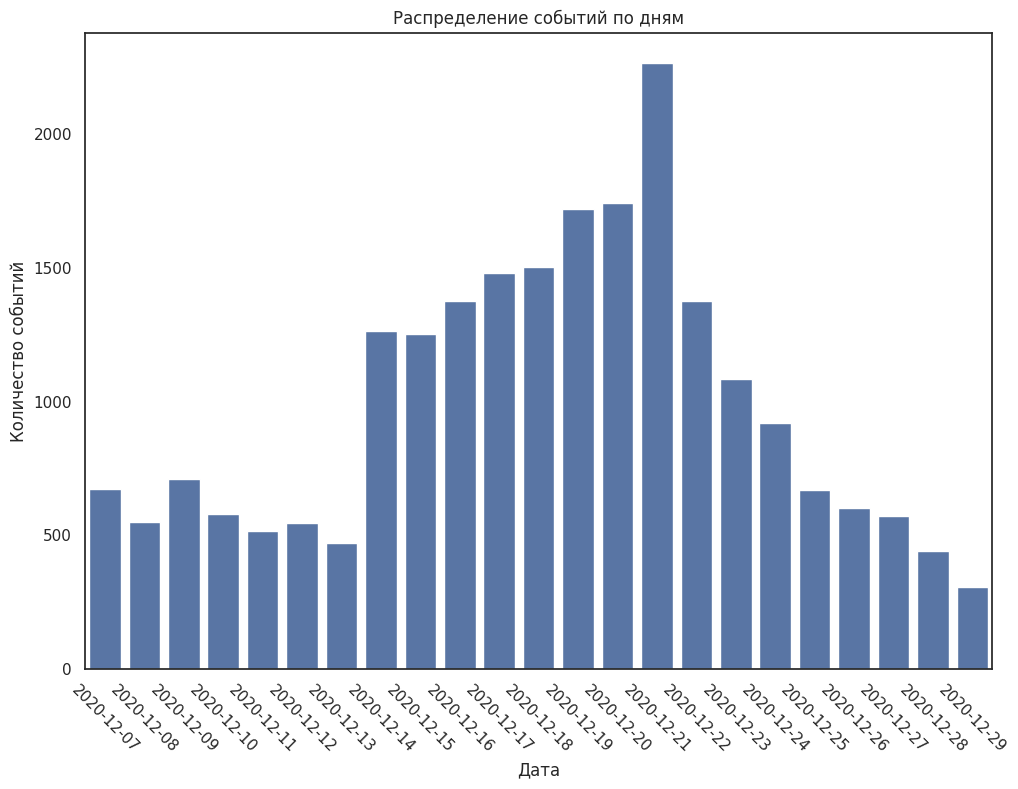

In [72]:
# Построим график распределения событий по дням проведения теста
sns.set(style='white', rc={'figure.figsize':(11.7,8.27)})
graf = sns.barplot(x= 'date', y = 'event_count', data=activity_caledar)
graf.set_title('Распределение событий по дням')
graf.set_xlabel('Дата')
graf.set_ylabel('Количество событий')
graf.tick_params(axis='x', rotation=-45)

Самая поздняя дата совершения событий пользователями - 29 декабря. Таким образом, не соблюдены условия ТЗ о длительности теста. По факту вместо 28 дней он длился 23 дня.

Из-за того, что фактическим окончанием теста можно считать дату 29 декабря 2020 г., не все пользователи имели шанс "прожить" 14 дней. Но в виду и без того больших потерь в данных из-за некорретности проведения теста, попробуем оценить, насколько критически важным является "доживание" до 14 дней. Для этого отдельно проанализируем, на какие дни в целом приходится совершение основных событий пользователями.

In [73]:
lifetime_calendar = ab_users.groupby(['lifetime'])['event_name'].count().reset_index()
lifetime_calendar.rename(columns = {'event_name':'event_count'}, inplace = True )
lifetime_calendar.head()

,lifetime,event_count
0,0,7719
1,1,3559
2,2,2451
3,3,1712
4,4,1417


Text(0, 0.5, 'Количество событий')

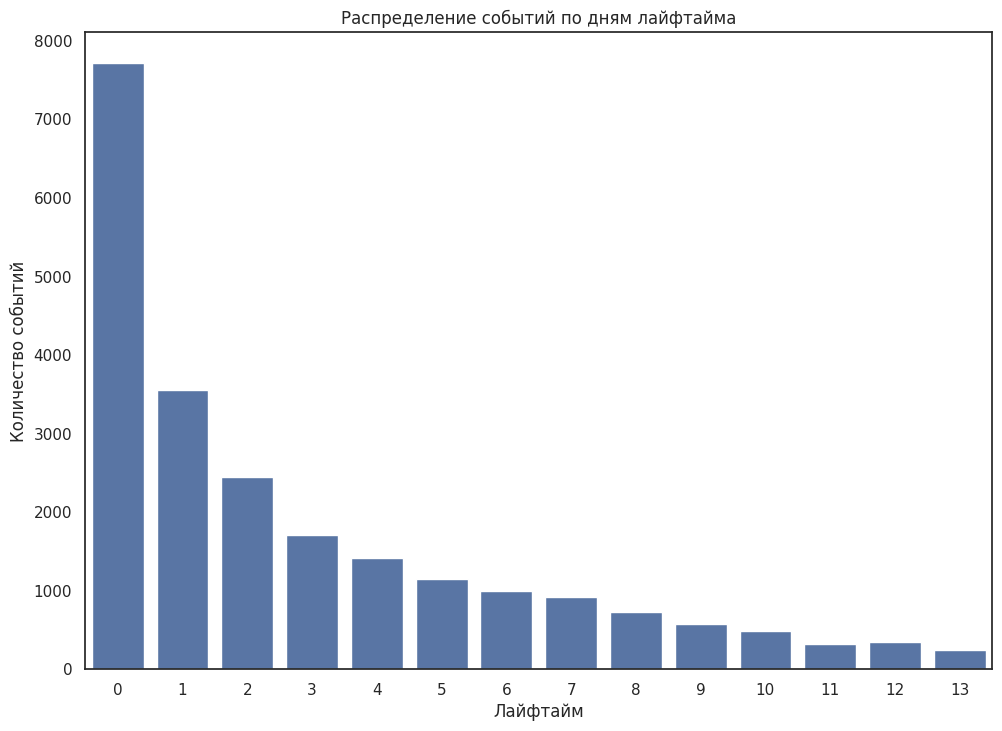

In [74]:
# Построим график распределения событий по дням лайтайма
sns.set(style='white', rc={'figure.figsize':(11.7,8.27)})
graf = sns.barplot(x= 'lifetime', y = 'event_count', data=lifetime_calendar)
graf.set_title('Распределение событий по дням лайфтайма')
graf.set_xlabel('Лайфтайм')
graf.set_ylabel('Количество событий')

In [75]:
purchases_all = ab_users.query('event_name == "purchase"')
purchases_calendar = purchases_all.groupby(['lifetime'])['event_name'].count().reset_index()
purchases_calendar.rename(columns = {'event_name':'purchases_count'}, inplace = True )
purchases_calendar.head()

,lifetime,purchases_count
0,0,1076
1,1,475
2,2,331
3,3,242
4,4,194


Text(0, 0.5, 'Количество покупок')

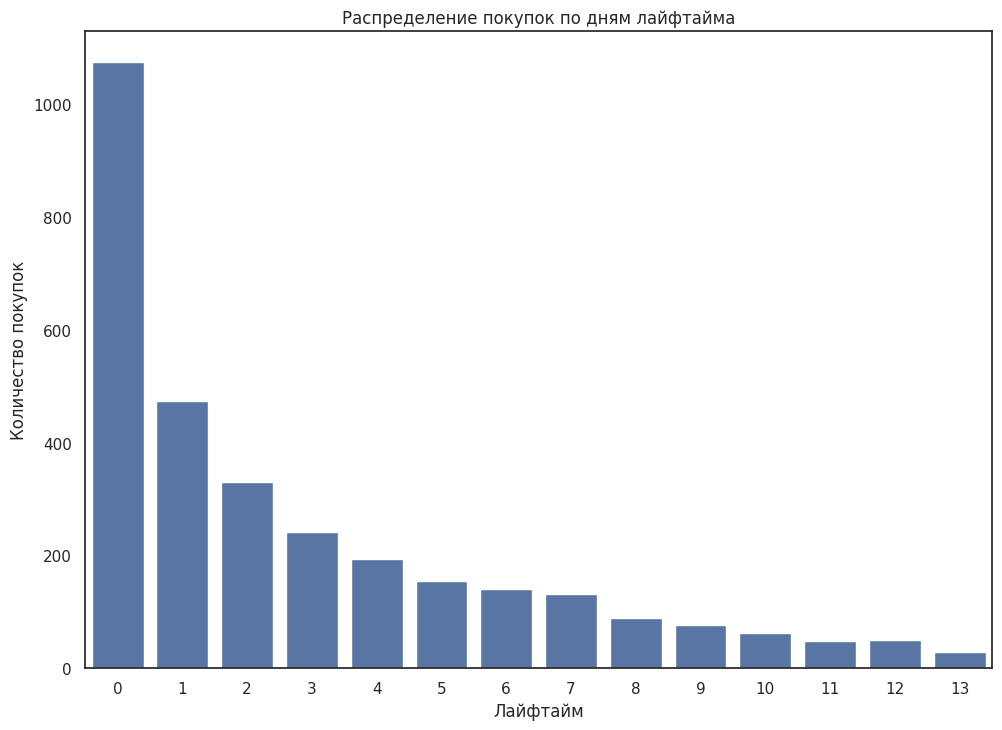

In [76]:
# Построим график распределения покупок по дням лайфтайма
sns.set(style='white', rc={'figure.figsize':(11.7,8.27)})
graf = sns.barplot(x= 'lifetime', y = 'purchases_count', data=purchases_calendar)
graf.set_title('Распределение покупок по дням лайфтайма')
graf.set_xlabel('Лайфтайм')
graf.set_ylabel('Количество покупок')

Все основные события пользователи совершают в течении первых 4-5 дней. Проверим, также, распределение только среди пользователей, проживших 14 дней, посмотрим на распределение совершения целевого действия по дням лайфтайма.

In [77]:
# уберем из выборки пользователей, дата регистрации которых - позднее 16 декабря
propper_lifetime_users = purchases_all.query('first_date <= "2020-12-16"')
propper_lifetime_users['first_date'].max()

Timestamp('2020-12-16 00:00:00')

In [78]:
lifetime_calendar = propper_lifetime_users.groupby(['lifetime'])['event_name'].count().reset_index()
lifetime_calendar.rename(columns = {'event_name':'purchases_count'}, inplace = True )
lifetime_calendar.head()

,lifetime,purchases_count
0,0,556
1,1,228
2,2,166
3,3,116
4,4,93


Text(0, 0.5, 'Количество покупок')

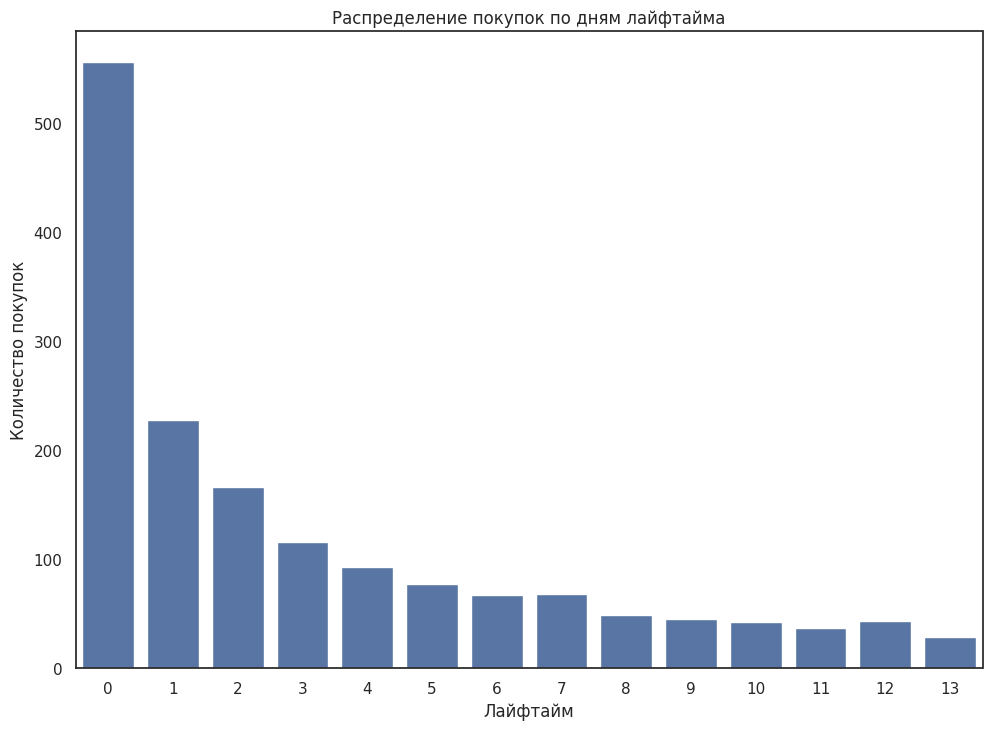

In [79]:
sns.set(style='white', rc={'figure.figsize':(11.7,8.27)})
graf = sns.barplot(x= 'lifetime', y = 'purchases_count', data=lifetime_calendar)
graf.set_title('Распределение покупок по дням лайфтайма')
graf.set_xlabel('Лайфтайм')
graf.set_ylabel('Количество покупок')

Проанализировав частоту всех событий, а также частоту целевого события "покупка" в распределении по дням лайфтайма, мы установили, что все основные события (в том числе и покупки) совершаются в течение 4-5 первых дней с момента регистрации пользователя. При аналие мы использовали как основной датасет со всеми пользователями, так и выборку только по тем пользователям, которые "прожили" 14 дней. Видимой разницы в частоте событий по дням лайфтайма между этими группами не наблюдается.     
Таким образом, целесообразнее будет оставить пользователей, не доживших несколько дней до 14 дневного срока, чем удалить их, существенно сократив выборку.

Проверим, не пересакаются ли даты проведения теста с маркетинговыми мероприятиями

In [80]:
marketing_events.query('"2020-12-07" < start_dt < "2021-01-03"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


В даты проведения теста попадает два меркетинговый события, но для европейского региона проводилось лишь одно из них - 'Christmas&New Year Promo'. Оно прошло с 25 декабря 2020 по 3 января 2021 года.

Проанализируем, повлияло ли проведение маркетинговой акции на целевое действие - совершение покупок

In [81]:
daily_purchases_calendar = purchases_all.groupby(['date'])['event_name'].count().reset_index()
daily_purchases_calendar.rename(columns = {'event_name':'purchases_count'}, inplace = True )
daily_purchases_calendar.head()

,date,purchases_count
0,2020-12-07,102
1,2020-12-08,66
2,2020-12-09,86
3,2020-12-10,68
4,2020-12-11,56


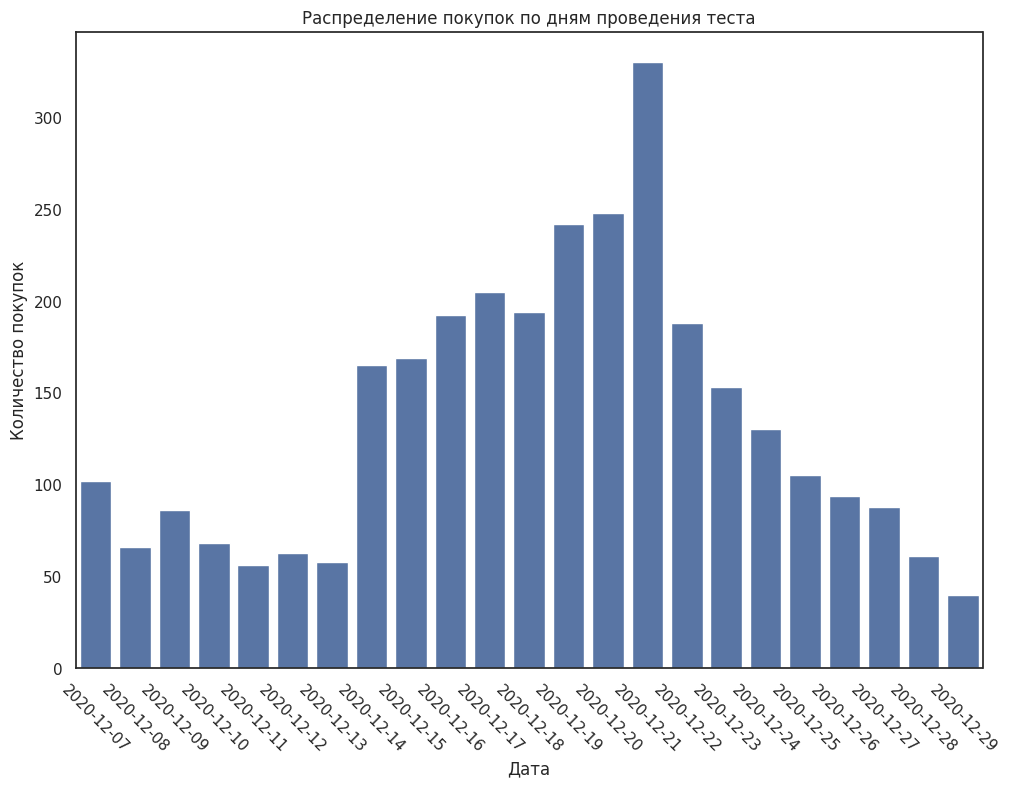

In [82]:
# Построим график распределения покупок по дням проведения теста
sns.set(style='white', rc={'figure.figsize':(11.7,8.27)})
graf = sns.barplot(x= 'date', y = 'purchases_count', data=daily_purchases_calendar)
graf.set_title('Распределение покупок по дням проведения теста')
graf.set_xlabel('Дата')
graf.set_ylabel('Количество покупок')
graf.tick_params(axis='x', rotation=-45)

С 7 до 14 декабря частота совершения покупок в целом падала, а начиная с 14 декабря резко возросла и продолжала расти. 21 декабря - пик покупок, а далее начался спад. К 26 декабря (времени начала маркетинговой акции) спад достиг значений, которые наблюдались до скачка продаж и уже до конца наблюдаемого периода эти значения только падают. При этом спад равномерный, без резких скачков, что позволяет предполагать, что маркетинговая акция не повлияла на эти показатели ни в положительном, ни в отрицательном значении.

### Вывод ###

- Даты начала (7.12.2020) и конца (21.12.2020) регистрации новых пользователей для участия в тесте соответствуют ТЗ.
- Из 6701 уникальных пользователей, принявших участие в тесте, 350 - не из региона EU. Это не соответствует ТЗ, пользователи были удалены из датасета.
- Количество пользователей, набранных в тест составялет 15% от новых пользователей из региона EU, что соответствует ТЗ.
- Группы А и В исследуемого теста не одинаковы по численности. В группе А изначально было 57.2% пользователей, а в группе B - 42.8% пользователей.
- 1602 пользователя пересекаются с конкурирующим тестом. Это 25.2% от всех участников теста.
- 819 пользователей из пересекающихся групп - из группы 'A' конкурирующего теста. Это значит, что над пользователями не производилось никаких действий. Но остальные 783 - из группы 'B', над которыми были совершены действия конкурирующего теста.  
- Мы проанализировали процент участников исследуемого теста, попавших также в группу B конкурирующего теста в распределении по группам A и B нашего теста. Получился примерно одинаковый процент распределения по группам A и B (12.1% и 12.7% соответственно). Таким образом, даже если эти участники продемонстрируют поведение, отличное от того, как если бы они не участвовали в конкурирующем тесте, эти изменения должны скомпенсироваться в обеих группах за счет равного распределения.  
- Дальнейшее исследование показало, что в датасете присутсвует 2870 пользователей, не совершивших ни одного действия. Т.к. эти пользователи будут бесполезны в расчете метрик, заданых в ТЗ, решено было исключить их из выборки, но при этом подробнее проанализировать их на этапе исследовательского анализа.
- После расчета лайфтайма для каждого события были выявлены события, совершенные позднее 14-го дня с момента регистрации пользователя. Согласно ТЗ мы анализируем данные на 14 день жизни пользователя. Все события, которые совершены после 14-го дня были исключены из датасета.  
- После очистки данных в датасете остался 3481 пользователь. Это существенные потери в данных, потребовавшие перерасчета распределения пользователей группам и доли пересечений с конкурирующим тестом.
- После очистки данных получилось соотношение группы А к группе В по количеству участников 74.8/25.2
- В группу В конкурирующего теста попал 431 пользователь из исследуемого теста.
- Несмотря на большие потери в данных и существенное изменение общего распределения пользователей исследуемого теста по группам А и В, распределение пользователей из группы В конкурирующего теста осталось приблизительно равным, 12.5% в группе А и 12.1% в группе В.
- Пересечения между группами А и В исследуемого теста отсутствуют.
- Самая поздняя дата совершения событий пользователями - 29 декабря. Таким образом, не соблюдены условия ТЗ о длительности теста. По факту вместо 28 дней он длился 23 дня.
- Проанализировав частоту всех событий, а также частоту целевого события "покупка" в распределении по дням лайфтайма, мы установили, что все основные события (в том числе и покупки) совершаются в течение 4-5 первых дней с момента регистрации пользователя. При аналие мы использовали как основной датасет со всеми пользователями, так и выборку только по тем пользователям, которые "прожили" 14 дней. Видимой разницы в частоте событий по дням лайфтайма между этими группами не наблюдается. Таким образом, целесообразнее оставить пользователей, не доживших несколько дней до 14 дневного срока, чем удалить их, существенно сократив выборку.
- В даты проведения теста попадает меркетинговое событие 'Christmas&New Year Promo', проводившееся в том числе и для европейского региона. Оно прошло с 25 декабря 2020 по 3 января 2021 года.
- С 7 до 14 декабря частота совершения покупок в целом падала, а начиная с 14 декабря резко возросла и продолжала расти. 21 декабря - пик покупок, а далее начался спад. К 26 декабря (времени начала маркетинговой акции) спад достиг значений, которые наблюдались до скачка продаж и уже до конца наблюдаемого периода эти значения только падают. При этом спад равномерный, без резких скачков, что позволяет предполагать, что маркетинговая акция не повлияла на эти показатели ни в положительном, ни в отрицательном значении.

Резюмируя всё выше перечисленное можно перечислить следующие существенные недочеты в проведении теста:
- В тест попали пользователи из конкурирующего тестав том числе из группы B, что так или иначе отразится на результатах теста
- Общая численность пользователей после очистки данных составила 3481. Это лишь 58% от предполагаемой численности в 6000 пользователей.
- Длительность теста вместо 28 дней составила 23 дня и часть пользователей не успели "прожить" 14 дней с момента регистрации.
- Распредление в группах А и В неравномерно и составляет 75%/25%
- На время проведения теста пришлась маркетинговая акция 'Christmas&New Year Promo', что так же может повлиять на результаты.
- Тест проводился во время рождественских и новогодних праздников, что тоже будет так или иначе влиять на результаты.     
Всё вышеперечисленное необходимо иметь в виду при оценке результатов теста.

## Исследовательский анализ данных ##

Проанализируем пользователей с нулевой активностью с целью получения дополнительной информации об этапе сбора данных для тестирования.

In [83]:
inactive_users.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
2,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,NaT,NaN,NaN
29,16C69ED14DA9F4A8,2020-12-07,EU,PC,B,recommender_system_test,NaT,NaN,NaN
33,2420EA89BB4BB0EA,2020-12-07,EU,iPhone,A,recommender_system_test,NaT,NaN,NaN
34,4D851A41ECF4440F,2020-12-07,EU,Android,B,recommender_system_test,NaT,NaN,NaN
74,8EB0C7622C73BBA3,2020-12-07,EU,Android,A,recommender_system_test,NaT,NaN,NaN


In [84]:
inactive_users.groupby('group')['user_id'].nunique()

group
A    1030
B    1840
Name: user_id, dtype: int64

Основная масса таких пользователей приходится на группу В - 1840 пользователей, что составляет 67.7% от всех участников группы В. В группе А 1030 таких пользователей, что составляет 28.3% от всех участников группы.

Попробуем отследить динамику набора таких пользователей с разбивкой по группам.

In [85]:
inactive_users_registration = inactive_users.groupby(['first_date', 'group'])['user_id'].nunique().reset_index()
inactive_users_registration.rename(columns = {'first_date':'registration_date', 'user_id':'user_count'}, inplace = True )
inactive_users_registration.sample()

,registration_date,group,user_count
15,2020-12-15,B,110


In [86]:
fig = px.bar(inactive_users_registration,
             x='registration_date',
             y='user_count',
             color='group',
             barmode='group',
             title='Распределение неактивных пользователей по дням регистрации')
fig.update_layout(yaxis=dict(title='Количество пользователей'),
                 xaxis=dict(title='Дата регистрации')
                 )
fig.update_xaxes(tickangle=45)
fig.show()

Пользователи с нулевой активностью регистрировались неравномерно. Начиная с 14 декабря набор таких пользователей в группу А прекратился, а в группе В регистрация таких пользователей продолжалась до конца набора. Такое резкое прекращение набора в одну из групп может говорить о каких-либо нарушениях при сборе данных. Таким образом, решение о том, чтобы отфильтровать таких пользователей, было верным.  

Изучим распределение по дням регистрации в обеих группах основного датасета

In [87]:
ab_users_registration = ab_users.groupby(['first_date', 'group'])['user_id'].nunique().reset_index()
ab_users_registration.rename(columns = {'first_date':'registration_date', 'user_id':'user_count'}, inplace = True )
ab_users_registration.sample()

,registration_date,group,user_count
24,2020-12-19,A,226


In [88]:
fig = px.bar(ab_users_registration,
             x='registration_date',
             y='user_count',
             color='group',
             barmode='group',
             title='Распределение пользователей по дням регистрации')
fig.update_layout(yaxis=dict(title='Количество пользователей'),
                 xaxis=dict(title='Дата регистрации')
                 )
fig.update_xaxes(tickangle=45)
fig.show()

В группу В больше всего пользователей пришло 7 декабря, самое малое количетсво пользователей в обеих группах зарегистрировалось 13 декабря. Далее 14 декабря мы наблюдаем резкий скачок регистраций, особенно в группе А. Пик регистраций в группе А приходится на 21 декабря.

In [89]:
# Распределение событий по группам
ab_users_activity = ab_users.groupby(['event_name', 'group'])['user_id'].count().reset_index()
ab_users_activity.rename(columns = {'user_id':'count'}, inplace = True )
ab_users_activity

,event_name,group,count
0,login,A,7907
1,login,B,2310
2,product_cart,A,2361
3,product_cart,B,617
4,product_page,A,5082
5,product_page,B,1240
6,purchase,A,2485
7,purchase,B,618


In [90]:
fig = px.bar(ab_users_activity,
             x='event_name',
             y='count',
             color='group',
             barmode='group',
             title='Количетсво событий по группам')
fig.update_layout(yaxis=dict(title='Количество событий'),
                 xaxis=dict(title='События')
                 )
fig.update_xaxes(tickangle=45)
fig.show()

Так как распределение пользователей по группам очень неравномерное, просто подсчет значений не очень информативен для сранения. Посчитаем для каждой группы процент событий по отношению с общим количеством событий.

In [91]:
activities_by_group = ab_users_activity.groupby('group')['count'].sum().reset_index()
activities_by_group.rename(columns = {'count':'count_all'}, inplace = True )

In [92]:
ab_users_activity_percent  = ab_users_activity.merge(activities_by_group, on='group', how='left').reset_index()
ab_users_activity_percent['percent'] = ((ab_users_activity_percent['count'] / ab_users_activity_percent['count_all']) * 100).round(1)
ab_users_activity_percent.head()

,index,event_name,group,count,count_all,percent
0,0,login,A,7907,17835,44.3
1,1,login,B,2310,4785,48.3
2,2,product_cart,A,2361,17835,13.2
3,3,product_cart,B,617,4785,12.9
4,4,product_page,A,5082,17835,28.5


In [93]:
fig = px.bar(ab_users_activity_percent,
             x='event_name',
             y='percent',
             color='group',
             barmode='group',
             title='Количество событий по группам в процентном отношении')
fig.update_layout(yaxis=dict(title='Процент событий'),
                 xaxis=dict(title='События')
                 )
fig.update_xaxes(tickangle=45)
fig.show()

Распределение частотности событий по группам выглядит следующим образом:
наиболее частое событие для обеих групп ожидаемо - логин, оно составляет почти 50% от всех прочих действий. Далее также для обеих групп идет страница продукта. На третьем месте у группы А - покупка, у группы В - корзина.

Посмотрим на распределение по устройствам в обеих группах

In [94]:
ab_users_devices = ab_users.groupby(['device', 'group'])['user_id'].nunique().reset_index()
ab_users_devices.rename(columns = {'user_id':'device_count'}, inplace = True )
ab_users_devices

,device,group,device_count
0,Android,A,1139
1,Android,B,405
2,Mac,A,255
3,Mac,B,74
4,PC,A,689
5,PC,B,212
6,iPhone,A,521
7,iPhone,B,186


In [95]:
fig = px.bar(ab_users_devices,
             x='device',
             y='device_count',
             color='group',
             barmode='group',
             title='Распределение пользователей по устройствам')
fig.update_layout(yaxis=dict(title='Количество пользователей'),
                 xaxis=dict(title='Устройства')
                 )
fig.update_xaxes(tickangle=45)
fig.show()

Распределение по устройствам в обеих группах одинаковое. Лидируют пользователи андроида, далее - пользователи PC, iPhone и самые малочисленные - пользователи Mac.

Сравним средние и медианные показатели суммы покупки в группах

In [96]:
ab_users.groupby('group')['details'].mean()

group
A    23.112736
B    23.032071
Name: details, dtype: float64

In [97]:
ab_users.groupby('group')['details'].median()

group
A    4.99
B    4.99
Name: details, dtype: float64

Медианные и средние показатели суммы покупок одинаковы для обеих групп.

Посчитаем количество событий на пользователя по группам

In [98]:
ab_users_mean_events_count = ab_users.groupby(['user_id', 'group'])['event_name'].count().reset_index()
ab_users_mean_events_count.rename(columns = {'event_name':'event_mean'}, inplace = True )
ab_users_mean_events_count.head()

,user_id,group,event_mean
0,001064FEAAB631A1,B,6
1,0010A1C096941592,A,12
2,00341D8401F0F665,A,2
3,003DF44D7589BBD4,A,15
4,00505E15A9D81546,A,5


Выведем среднее количество действий на пользователя для группы А

In [99]:
ab_users_mean_events_count.query('group == "A"')['event_mean'].describe()

count    2604.000000
mean     6.849078   
std      3.812030   
min      1.000000   
25%      4.000000   
50%      6.000000   
75%      9.000000   
max      24.000000  
Name: event_mean, dtype: float64

Среднее количество действий на пользователя в группе А = 7 действий, медианное значение - 6 действий.

Выведем среднее количество действий на пользователя для группы В

In [100]:
ab_users_mean_events_count.query('group == "B"')['event_mean'].describe()

count    877.000000
mean     5.456100  
std      3.246276  
min      1.000000  
25%      3.000000  
50%      4.000000  
75%      8.000000  
max      24.000000 
Name: event_mean, dtype: float64

Среднее количество действий на пользователя в группе В = 5 действий, медианное значение - 4 действия.

Посчитаем число событий по дням для каждой группы, а также процентное соотношение относительно общего числа событий

In [101]:
ab_users_events_daily = ab_users.groupby(['date', 'group'])['event_name'].count().reset_index()
ab_users_events_daily.rename(columns = {'event_name':'event_count'}, inplace = True )
ab_users_events_daily.head()

,date,group,event_count
0,2020-12-07,A,318
1,2020-12-07,B,356
2,2020-12-08,A,313
3,2020-12-08,B,238
4,2020-12-09,A,371


In [102]:
ab_events_all = ab_users_events_daily.groupby(['group'])['event_count'].sum().reset_index()
ab_events_all.rename(columns = {'event_count':'all_events_count'}, inplace = True)
ab_users_events_daily = ab_users_events_daily.merge(ab_events_all, on='group', how='left').reset_index()
ab_users_events_daily.head()

,index,date,group,event_count,all_events_count
0,0,2020-12-07,A,318,17835
1,1,2020-12-07,B,356,4785
2,2,2020-12-08,A,313,17835
3,3,2020-12-08,B,238,4785
4,4,2020-12-09,A,371,17835


In [103]:
ab_users_events_daily['percent'] = ((ab_users_events_daily['event_count'] / ab_users_events_daily['all_events_count']) * 100).round(1)
ab_users_events_daily.head()

,index,date,group,event_count,all_events_count,percent
0,0,2020-12-07,A,318,17835,1.8
1,1,2020-12-07,B,356,4785,7.4
2,2,2020-12-08,A,313,17835,1.8
3,3,2020-12-08,B,238,4785,5.0
4,4,2020-12-09,A,371,17835,2.1


In [104]:
fig = px.bar(ab_users_events_daily,
             x='date',
             y='event_count',
             color='group',
             barmode='group',
             title='Распределение количества событий по дням')
fig.update_layout(yaxis=dict(title='Количество событий'),
                 xaxis=dict(title='Дата')
                 )
fig.update_xaxes(tickangle=45)
fig.show()

In [105]:
fig = px.bar(ab_users_events_daily,
             x='date',
             y='percent',
             color='group',
             barmode='group',
             title='Распределение количества событий по дням в процентном соотношении')

fig.update_layout(yaxis=dict(title='Процент активности'),
                 xaxis=dict(title='Дата')
                 )
fig.update_xaxes(tickangle=45)
fig.show()

В группе А до 14 декабря наблюдается самая низкая активность. Начиная с 14 декабря - резкий скачок и рост вплоть до 21 декабря. 21 - пик активности и далее постепенный спад, вплоть до конца наблюдаемого периода.
В группе В более скачкообразная активность. Пики активности - 7, 9, 16, 21 декабря. 21 декабря, как и в группе А - пик активности за весь наблюдаемый период, но не такой разительный по отношению к другим дням, как у группы А. Пики активности приходятся на понедельники и среды, возможно, в эти дни поступали рекомендации от сервиса, либо ещё как-то стимулировалась активность.

### Вывод ###
- Анализ пользователей с нулевой активностью показал, что основная масса таких пользователей пришлось на группу В - 1840 пользователей, что составило 67.7% от всех участников группы В. В группе А было 1030 таких пользователей, что составило 28.3% от всех участников группы.
- Пользователи с нулевой активностью регистрировались неравномерно. Начиная с 14 декабря набор таких пользователей в группу А прекратился, а в группе В регистрация таких пользователей продолжалась до конца набора. Такое резкое прекращение набора в одну из групп может говорить о каких-либо нарушениях при сборе данных. Если бы регистрация проходила равномерно по обеим группам, можно было бы учесть этих пользователей в общем датасете. Но в случае технического сбоя данные становятся некорректными. Таким образом, решение о том, чтобы отфильтровать таких пользователей, было верным.  
- В группу В больше всего пользователей пришло 7 декабря, самое малое количетсво пользователей в обеих группах зарегистрировалось 13 декабря. Далее 14 декабря мы наблюдаем резкий скачек регистраций, особенно в группе А. Пик регистраций в группе А приходится на 21 декабря.
- Распределение частотности событий по группам выглядит следующим образом: наиболее частое событие для обеих групп ожидаемо - логин, оно составляет почти 50% от всех прочих действий. Далее также для обеих групп идет страница продукта. На третьем месте у группы А - покупка, у группы В - корзина.
- Среднее количество действий на пользователя в группе А = 7 действий, медианное значение - 6 действий.
- Среднее количество действий на пользователя в группе В = 5 действий, медианное значение - 4 действия.
- В группе А до 14 декабря наблюдается самая низкая активность. Начиная с 14 декабря - резкий скачок и рост вплоть до 21 декабря. 21 - пик активности и далее постепенный спад, вплоть до конца наблюдаемого периода.
- В группе В более скачкообразная активность. Пики активности - 7, 9, 16, 21 декабря. 21 декабря, как и в группе А - пик активности за весь наблюдаемый период, но не такой разительный по отношению к другим дням, как у группы А. Пики активности приходятся на понедельники и среды, возможно, в эти дни поступали рекомендации от сервиса, либо ещё как-то стимулировалась активность.

## Оценка результатов A/B-тестирования ##

### Изучение воронки событий по группам

Подготовим данные для построения воронки событий

In [106]:
# Выведем таблицу с показателями воронки событий для каждой группы
pivot_groups = (ab_users
                .pivot_table(index='event_name',
                             values='user_id',
                             columns='group',
                             aggfunc=lambda x: x.nunique()).reset_index())
pivot_groups

group,event_name,A,B
0,login,2604,876
1,product_cart,782,244
2,product_page,1685,493
3,purchase,833,249


Получилось, что воронка не заканчивается целевым событием. Это могло быть потому, что товар можно купить, минуя корзину. Померяем порядок событий.

In [107]:
pivot_groups = pivot_groups.reindex([0,2,1,3]).reset_index()
pivot_groups

group,index,event_name,A,B
0,0,login,2604,876
1,2,product_page,1685,493
2,1,product_cart,782,244
3,3,purchase,833,249


In [108]:
# построим воронку конверсии событий по группам
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = pivot_groups['event_name'],
    x = pivot_groups['A'],
    marker = {"color": ["#d5a6bd", "#d5a6bd", "#d5a6bd", "#d5a6bd"],
    "line": {"width": [2, 2, 2, 2, 2], "color": ["gray", "gray", "gray", "gray"]}},
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y = pivot_groups['event_name'],
    x = pivot_groups['B'],
    marker = {"color": ["#b4a7d6", "#b4a7d6", "#b4a7d6", "#b4a7d6"],
    "line": {"width": [2, 2, 2, 2, 2], "color": ["gray", "gray", "gray", "gray"]}},
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.update_layout(title_text = 'Воронка конверсии событий по группам')
fig.show()

Пользователей, перешедших от логина до страницы продукта 65% в группе А и 56% в группе В    
Пользователей, перешедших со страницы продукта в корзину 30% в группе А и 28% в группе В    
Пользователей, перешедших со страницы корзины к покупке 32% в группе А и 28% в группе В    
Мы видим, что показатели конверсии в группе B не показывают ожидаемого увеличения на 10% по сравнению с группой А, а даже несколько ниже, чем в контрольной группе.  

### Гипотеза о различии показателей воронки событий между группами

In [109]:
# Напишем функцию для проверки гипотез
def hypothesis_test (success1, success2, trials1, trials2, alpha):
    # пропорция успехов в первой группе:
    p1 = success1 / trials1
    # пропорция успехов во второй группе:
    p2 = success2 / trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (success1 + success2) / (trials1 + trials2)
    # разница пропорций в датасетах
    difference = p1 - p2

    z_value = difference / math.sqrt(p_combined *(1-p_combined) * (1/trials1 + 1/trials2))

    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

Чтобы избежать ложнопозитивных и ложнонегативных результатов при множественном тестировании, применим коррекцию уровня статистической значимости по методу Шидака

In [110]:
# применяем коррекцию стат. значимости
alfa_corrected = 1 - (1 - 0.05)**(1/3)
alfa_corrected

0.016952427508441503

- **H<sub>0</sub>** различий в показателях воронки событий между группами А и В нет.
- **H<sub>1</sub>** различия в показателях воронки событий между группами А и В есть.

In [111]:
pivot_groups

group,index,event_name,A,B
0,0,login,2604,876
1,2,product_page,1685,493
2,1,product_cart,782,244
3,3,purchase,833,249


In [112]:
# вызовем функцию для событий воронки в обеих группах
for events in pivot_groups.index[1:4]:
    print('Результат проверки гипотезы для события', pivot_groups.loc[events, 'event_name'])
    hypothesis_test(pivot_groups.loc[events, 'A'],
                           pivot_groups.loc[events, 'B'],
                           pivot_groups.loc[0, 'A'],
                           pivot_groups.loc[0, 'B'],
                           alpha=alfa_corrected)
    print()

Результат проверки гипотезы для события product_page
p-значение:  8.195976000324734e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


Результат проверки гипотезы для события product_cart
p-значение:  0.2215941567364419
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результат проверки гипотезы для события purchase
p-значение:  0.04864766695042433
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Результаты теста показали, что между группой А, в которой не проводилось изменений и группой В, для которой была изменена рекомендательная система статистически значимое различие есть только для конверсии в карточу товара. Но это различие не в пользу группы B. По конверсии в корзину и покупки статистической значимости между группами не обнаружено.  

### Вывод ###
Анализ воронки событий показал следующее:
- Пользователей, перешедших от логина до страницы продукта 65% в группе А и 56% в группе В
- Пользователей, перешедших со страницы продукта в корзину 30% в группе А и 28% в группе В
- Пользователей, перешедших со страницы корзины к покупке 32% в группе А и 28% в группе В
Получилось, что конверсия в покупку выше конверсии в корзину. Это могло быть потому, что товар можно купить, минуя корзину.    
Показатели конверсии в группе B не показывают ожидаемого увеличения на 10% по сравнению с группой А, а даже несколько ниже, чем в контрольной группе.     
Результаты статтеста показали, что между группой А, в которой не проводилось изменений и группой В, для которой была изменена рекомендательная система статистически значимое различие есть только для конверсии в карточу товара. Но это различие не в пользу группы Б. По конверсии в корзину и покупки статистической значимости между группами не обнаружено.

## Общий вывод ##

При предобработке данных и анализе их на соответствие ТЗ были выявлены следующие нарушения в проведении теста:
- В тест попали пользователи из конкурирующего тестав том числе из группы B, что так или иначе отразится на результатах теста
- Общая численность пользователей после очистки данных составила 3481. Это лишь 58% от предполагаемой численности в 6000 пользователей.
- Длительность теста вместо 28 дней составила 23 дня и часть пользователей не успели "прожить" 14 дней с момента регистрации.
- Распредление в группах А и В неравномерно и после очистки данных составило 75%/25%
- На время проведения теста пришлась маркетинговая акция 'Christmas&New Year Promo', что также могло повлиять на результаты.
- Тест проводился во время рождественских и новогодних праздников, что тоже так или иначе повлияло на результаты.     
Всё вышеперечисленное необходимо иметь в виду при принятии решений на основе результатов теста.

Исследовательский анализ показал следующее:
- Анализ пользователей с нулевой активностью показал, что основная масса таких пользователей пришлось на группу В - 1840 пользователей, что составило 67.7% от всех участников группы В. В группе А было 1030 таких пользователей, что составило 28.3% от всех участников группы.
- Пользователи с нулевой активностью регистрировались неравномерно. Начиная с 14 декабря набор таких пользователей в группу А прекратился, а в группе В регистрация таких пользователей продолжалась до конца набора. Такое резкое прекращение набора в одну из групп может говорить о каких-либо нарушениях при сборе данных. Если бы регистрация проходила равномерно по обеим группам, можно было бы учесть этих пользователей в общем датасете. Но в случае технического сбоя данные становятся некорректными. Таким образом, решение о том, чтобы отфильтровать таких пользователей, было верным.  
- В группу В больше всего пользователей пришло 7 декабря, самое малое количетсво пользователей в обеих группах зарегистрировалось 13 декабря. Далее 14 декабря мы наблюдаем резкий скачок регистраций, особенно в группе А. Пик регистраций в группе А приходится на 21 декабря.
- Распределение частотности событий по группам выглядит следующим образом: наиболее частое событие для обеих групп ожидаемо - логин, оно составляет почти 50% от всех прочих действий. Далее также для обеих групп идет страница продукта. На третьем месте у группы А - покупка, у группы В - корзина.
- Среднее количество действий на пользователя в группе А = 7 действий, медианное значение - 6 действий.
- Среднее количество действий на пользователя в группе В = 5 действий, медианное значение - 4 действия.
- В группе А до 14 декабря наблюдается самая низкая активность. Начиная с 14 декабря - резкий скачок и рост вплоть до 21 декабря. 21 - пик активности и далее постепенный спад, вплоть до конца наблюдаемого периода.
- В группе В более скачкообразная активность. Пики активности - 7, 9, 16, 21 декабря. 21 декабря, как и в группе А - пик активности за весь наблюдаемый период, но не такой разительный по отношению к другим дням, как у группы А. Пики активности приходятся на понедельники и среды, возможно, в эти дни поступали рекомендации от сервиса, либо ещё как-то стимулировалась активность.

Анализ воронки событий показал следующее:
- Пользователей, перешедших от логина до страницы продукта 65% в группе А и 56% в группе В
- Пользователей, перешедших со страницы продукта в корзину 30% в группе А и 28% в группе В
- Пользователей, перешедших со страницы корзины к покупке 32% в группе А и 28% в группе В
Получилось, что конверсия в покупку выше конверсии в корзину. Это могло быть потому, что товар можно купить, минуя корзину.    
Показатели конверсии в группе B не показывают ожидаемого увеличения на 10% по сравнению с группой А, а даже несколько ниже, чем в контрольной группе.     
Результаты статтеста показали, что между группой А, в которой не проводилось изменений и группой В, для которой была изменена рекомендательная система статистически значимое различие есть только для конверсии в карточу товара. Но это различие не в пользу группы Б. По конверсии в корзину и покупки статистической значимости между группами не обнаружено.

По результатам проведенного анализа можно заключить, что изменение рекомендательной системы не показало ожидаемых результатов улучшения конверсии воронки событий. Показатели конверсии в экспериментальной группе целом несколько хуже, чем в контрольной группе. Однако, тест был проведен с рядом нарушений и целиком полагаться на его результаты нельзя.

Для принятия решения стоит оценить затраты на проведение А/В теста в сравнении с затратами на разработанную систему рекомендаций.
Если затраты на проведения ещё одного теста намного меньше, чем было потрачено на разработку, рекомендуется провести ещё один тест, соблюдая следующие рекомендации:
- не проводить тест в высокий и низкие сезоны и периоды праздников
- не доспускать пересечения по пользователям с конкурирующими тестами
- строго соблюсти сроки проведения теста
- обеспечить достаточный набор участников для проведения теста
Ниже приведен рассчет численности каждой группы для проведения A/B теста, где за базовую конверсию принята конверсия группы А за неимением информации о базовой конверсии, от которой планируется увидеть улучшения.     



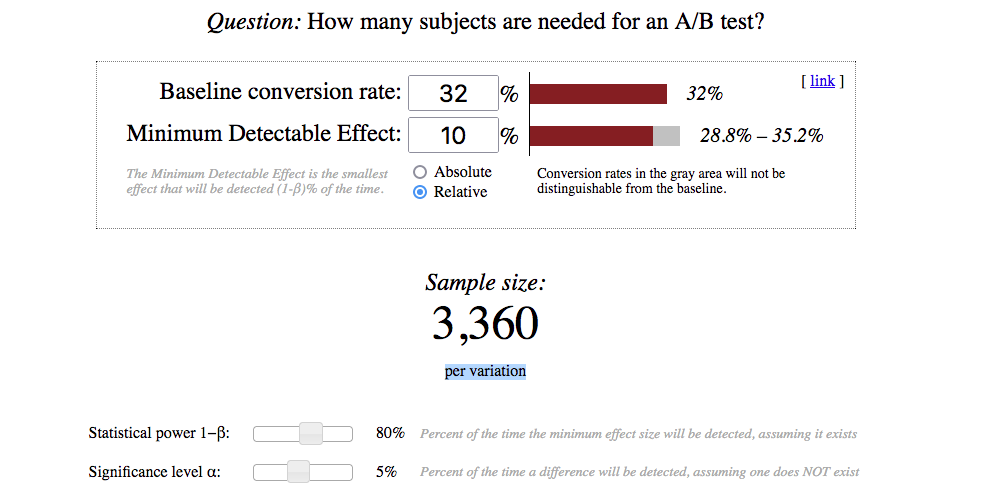

Исходя из этих расчетов в каждой группе должно быть не менее 3 360 пользователей.

В случае, если стоимость повторного проведения теста будет намного превышать средства, затраченные на разработку, рекомендовано признать результаты теста достоверными и отказаться от внедрения новой системы рекомендаций.